In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [15]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from collections import Counter
from sklearn.metrics import confusion_matrix
import itertools
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.model_selection import train_test_split

%matplotlib inline

In [16]:
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
print(train.shape)
train.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:

#label counts
count_labels = Counter(train['label'])
print(count_labels)

Counter({1: 4684, 7: 4401, 3: 4351, 9: 4188, 2: 4177, 6: 4137, 0: 4132, 4: 4072, 8: 4063, 5: 3795})


<Axes: ylabel='count'>

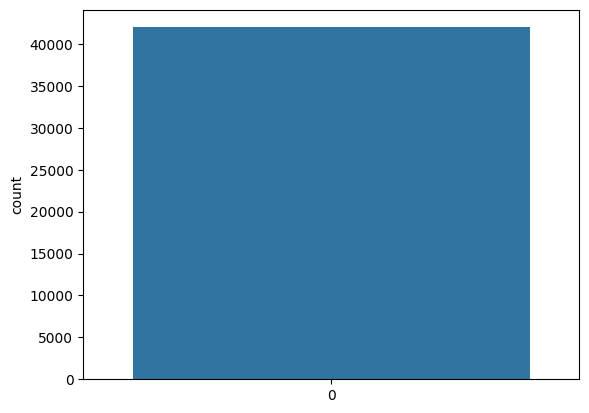

In [18]:
#visualize label count
sns.countplot(train['label'])

In [19]:
#features
x_train = (train.iloc[:,1:].values).astype('float32')
#labels
y_train = train.iloc[:, 0].values.astype('int32')

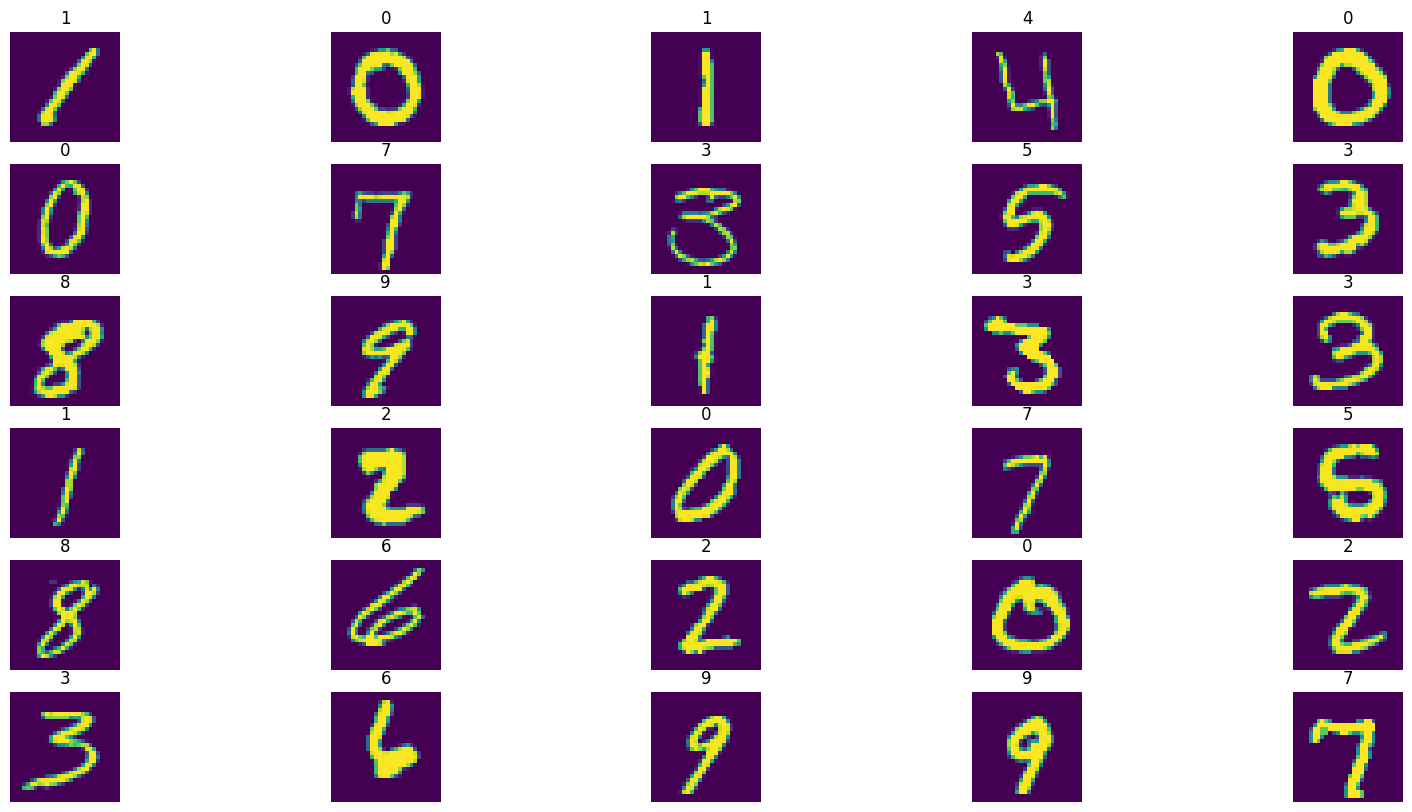

In [20]:
plt.figure(figsize=(20,10))
x, y = 5, 6
for i in range(30):
    plt.subplot(y, x, i+1)
    plt.title(str(y_train[i]))
    plt.imshow(x_train[i].reshape((28,28)))
    plt.axis("off")
plt.show()

In [21]:
x_train = x_train/255.0
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.3)

In [22]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'validation samples')

x_train shape: (29400, 784)
29400 train samples
12600 validation samples


In [28]:
# If x_train is a NumPy array and needs to be converted to a tensor
if isinstance(x_train, np.ndarray):
    x_train = torch.from_numpy(x_train)

# Ensure y_train is a tensor and convert its data type to LongTensor if it's not already
if not torch.is_tensor(y_train):
    y_train = torch.from_numpy(y_train)
y_train = y_train.long() # This is the correct method to ensure y_train is of type LongTensor

# If x_val is a NumPy array and needs to be converted to a tensor
if isinstance(x_val, np.ndarray):
    x_val = torch.from_numpy(x_val)

if not torch.is_tensor(y_val):
    y_val = torch.from_numpy(y_val)
y_val = y_val.long()


In [29]:
BATCH_SIZE = 64
EPOCHS = 20
INPUT_DIM = 28 * 28
OUTPUT_DIM = 10
train = torch.utils.data.TensorDataset(x_train,y_train)
val = torch.utils.data.TensorDataset(x_val, y_val)
data_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE)
val_loader = torch.utils.data.DataLoader(val, batch_size=BATCH_SIZE)

In [30]:
class CNN_MNIST(nn.Module):
    """
    Our model's Class inherit from nn.Module
    """
    def __init__(self):
        super(CNN_MNIST, self).__init__()
        #Conv1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5)
        self.batch_norm1 = nn.BatchNorm2d(16)
        self.drop1 = nn.Dropout2d(p=0.2)
        
        #Conv2
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5)
        self.batch_norm2 = nn.BatchNorm2d(32)
        self.drop2 = nn.Dropout2d(p=0.5)
        
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        self.fc1 = nn.Linear(32 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.drop1(self.batch_norm1(self.conv1(x)))))
        x = self.pool(F.relu(self.drop2(self.batch_norm2(self.conv2(x)))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [31]:
model = CNN_MNIST() #our model
error = nn.CrossEntropyLoss() #Cross entropy loss because we have many classes (10)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.003, momentum=0.5) # 

In [35]:
def fit(model, data, optimizer, loss_function, phase='training', batch_size=64, is_cuda=False):
    """
    Train or validate the model.
    """
    if phase == 'training':
        model.train()
    else:
        model.eval()
    
    loss_values = 0.0
    correct_values = 0
    for batch_idx, (image, label) in enumerate(data):
        if is_cuda:
            image, label = image.cuda(), label.cuda()
        
        image, label = image.view(-1, 1, 28, 28), label
        
        if phase == 'training':
            optimizer.zero_grad()
        
        output = model(image)
        loss = loss_function(output, label)
        loss_values += loss.item()  # Ensure scalar value is used for addition
        predictions = output.max(1, keepdim=True)[1]  # Simplify max operation
        correct_values += predictions.eq(label.view_as(predictions)).sum().item()
        
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    total_size = len(data.dataset)
    loss = loss_values / total_size
    accuracy = 100. * correct_values / total_size
    print(f'\n{phase} loss is {loss:.2f} and {phase} accuracy is {accuracy:.4f}%\n' + '='*45)
    
    return loss, accuracy


In [39]:
import torch.optim as optim
import torch.nn as nn

# Example definitions for the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adjust parameters as needed
loss_function = nn.CrossEntropyLoss()  # Or another loss function suited to your problem

# Initialization of lists for tracking metrics
train_loss_list, val_loss_list = [], []
train_accuracy_list, val_accuracy_list = [], []

for epoch in range(EPOCHS):
    print(f'Epoch {epoch+1}/{EPOCHS}')

    # Training phase
    train_epoch_loss, train_epoch_accuracy = fit(
        model=model,
        data=data_loader,
        optimizer=optimizer,
        loss_function=loss_function,
        phase='training',
        batch_size=BATCH_SIZE,
        is_cuda=False  # Set to True if you are using GPU
    )

    # Validation phase
    val_epoch_loss, val_epoch_accuracy = fit(
        model=model,
        data=val_loader,
        optimizer=optimizer,  # Note: optimizer is passed for consistency but not used in validation
        loss_function=loss_function,
        phase='validation',
        batch_size=BATCH_SIZE,
        is_cuda=False  # Match this with the training phase
    )
    
    # Append metrics to lists for tracking
    train_loss_list.append(train_epoch_loss)
    train_accuracy_list.append(train_epoch_accuracy)
    val_loss_list.append(val_epoch_loss)
    val_accuracy_list.append(val_epoch_accuracy)


Epoch 1/20

training loss is 0.01 and training accuracy is 88.9184%

validation loss is 0.00 and validation accuracy is 96.9603%
Epoch 2/20

training loss is 0.00 and training accuracy is 95.6429%

validation loss is 0.00 and validation accuracy is 97.9127%
Epoch 3/20

training loss is 0.00 and training accuracy is 96.6395%

validation loss is 0.00 and validation accuracy is 98.1984%
Epoch 4/20

training loss is 0.00 and training accuracy is 97.0918%

validation loss is 0.00 and validation accuracy is 98.3095%
Epoch 5/20

training loss is 0.00 and training accuracy is 97.4796%

validation loss is 0.00 and validation accuracy is 98.5159%
Epoch 6/20

training loss is 0.00 and training accuracy is 97.8639%

validation loss is 0.00 and validation accuracy is 98.7063%
Epoch 7/20

training loss is 0.00 and training accuracy is 97.8333%

validation loss is 0.00 and validation accuracy is 98.9524%
Epoch 8/20

training loss is 0.00 and training accuracy is 97.9966%

validation loss is 0.00 and 

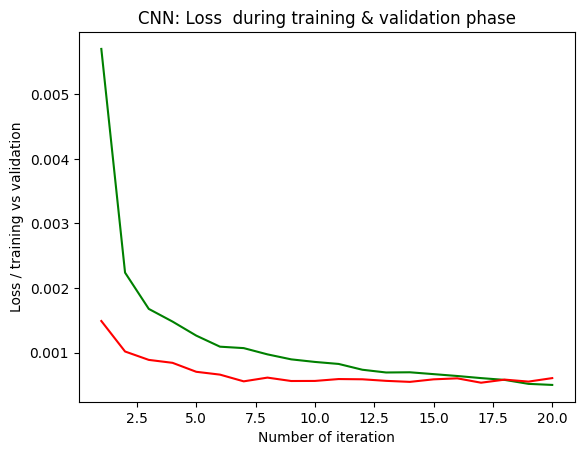

In [42]:
#LOSS PLOT
plt.plot(range(1, len(train_loss_list)+1), train_loss_list,'g', label = 'Training')
plt.plot(range(1, len(val_loss_list)+1), val_loss_list,'r', label = 'Validation')
plt.xlabel("Number of iteration")
plt.ylabel("Loss / training vs validation")
plt.title("CNN: Loss  during training & validation phase")
plt.show()

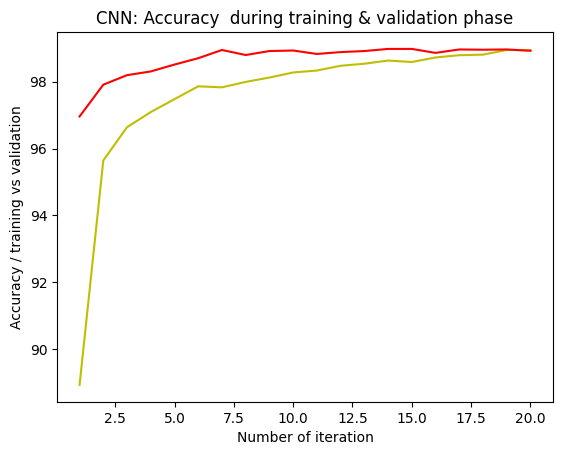

In [43]:
#ACCURACY PLOT
plt.plot(range(1, len(train_accuracy_list)+1), train_accuracy_list,'y', label = 'Training')
plt.plot(range(1, len(val_accuracy_list)+1), val_accuracy_list,'r', label = 'Validation')
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy / training vs validation")
plt.title("CNN: Accuracy  during training & validation phase")
plt.show()

In [44]:
def predict(model, data):
    model.eval()
    test_predictions = torch.LongTensor()
    for batch_idx, (image,) in enumerate(data):
        image = Variable(image.view(1, 1, 28, 28))
        output = model(image)
        prediction = output.data.max(dim=1, keepdim=True)[1]
        test_predictions = torch.cat((test_predictions, prediction), dim=0)
    return test_predictions

In [48]:
#TEST SET
test_set= pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
print(test_set.shape)
x_test = test_set.values.astype('float32')
X_test = x_test/255.0 # Normalize
X_test = torch.from_numpy(X_test) #make it as torch tensor
test = torch.utils.data.TensorDataset(X_test)
test_loader = torch.utils.data.DataLoader(test)
predictions = predict(model, test_loader)

(28000, 784)


In [49]:
pred_df = pd.DataFrame(np.c_[np.arange(1, len(test_set)+1)[:,None], predictions.numpy()], 
                      columns=['ImageId', 'Label'])
pred_df.to_csv('submission.csv', index=False)

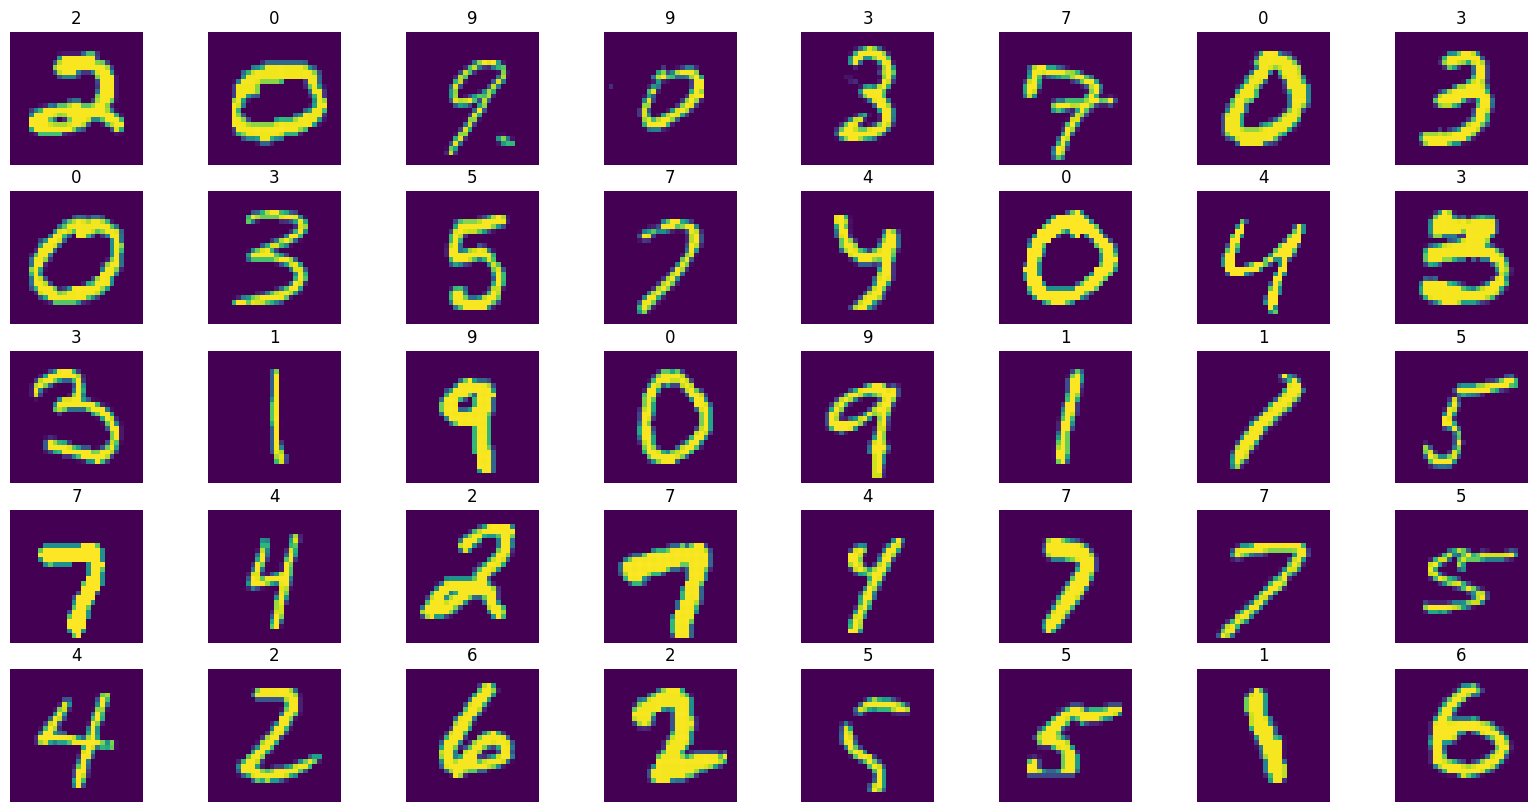

In [50]:
plt.figure(figsize=(20,10))
x, y = 8, 5
for i in range(40):  
    plt.subplot(y, x, i+1)
    plt.title(str(pred_df.iloc[i,1]))
    plt.imshow(x_test[i].reshape((28,28)))
    plt.axis("off")
plt.show()